In [1]:
%matplotlib inline
import numpy as np
import lsst.sims.utils as utils
import healpy as hp
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u
from astropy.time import Time

In [2]:
# Create a simple map
nside = 256
ra, dec = utils._hpid2RaDec(nside, np.arange(hp.nside2npix(nside)))
coord = SkyCoord(ra=ra*u.rad,dec=dec*u.rad)
g_long, g_lat = coord.galactic.l.radian, coord.galactic.b.radian #utils._galacticFromEquatorial(ra,dec)
eclip_long, eclip_lat = coord.barycentrictrueecliptic.lon.radian, coord.barycentrictrueecliptic.lat.radian

In [3]:
galactic_lat_max = 10.
main_dec = 0
main_weight = 1.

south_dec = -60
south_weight = 0.4

nes_dec = 0.
nes_eclip = 15.
nes_weight = 0.5

gal_lat = 10.
gal_long_end1 = 70.
gal_long_end2 = 270.
gal_weight = 0.2

In [4]:
regionMap = np.zeros(hp.nside2npix(nside))+hp.UNSEEN
# Set everything below dec <= 0 to be one
regionMap[np.where(dec <= np.radians(main_dec))] = main_weight
# Set the South Region 
regionMap[np.where(dec < np.radians(south_dec))] = south_weight
# Set the NES
regionMap[np.where((dec > np.radians(nes_dec)) & (eclip_lat < np.radians(nes_eclip)))] = nes_weight
# Set the Galactic Plane
regionMap[np.where( (np.abs(g_lat) < np.radians(gal_lat)) & (g_long < np.radians(gal_long_end1)) )] = gal_weight
regionMap[np.where( (np.abs(g_lat) < np.radians(gal_lat)) & (g_long > np.radians(gal_long_end2)) )] = gal_weight

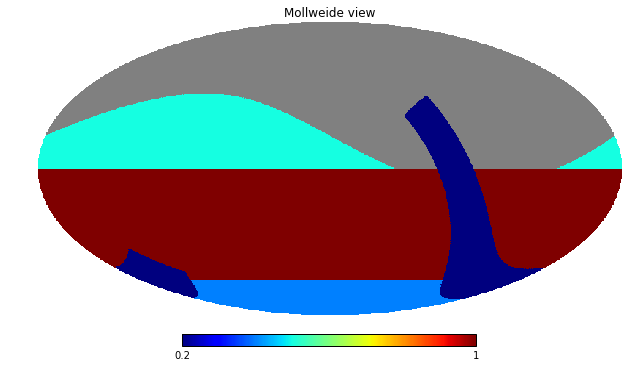

In [5]:
hp.mollview(regionMap)

In [6]:
regionMap.size

786432

In [7]:
# Let's load up some r-band data and see what a desireability map might look like
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

In [8]:
# Set up the database connection
opsdb = db.OpsimDatabase('ewok_1004_sqlite.db')
outDir = 'null'
resultsDb = db.ResultsDb(outDir=outDir)
nyears = 1.3
sql = 'night < %i and filter="r"' % (365.25*nyears) 
slicer = slicers.HealpixSlicer(nside=nside, lonCol='ditheredRA', latCol='ditheredDec')
metric = metrics.CountMetric(col='expMJD')
bundleList = [metricBundles.MetricBundle(metric,slicer,sql)]
metric=metrics.MaxMetric(col='expMJD')
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Querying database with constraint night < 474 and filter="r"
Found 58571 visits
Running:  ['opsim_Max_expMJD_night_lt_474_and_r_HEAL', 'opsim_Count_expMJD_night_lt_474_and_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [9]:
date = np.max(bundleList[-1].metricValues)

In [10]:
# try making an alt,az map.
site =utils.Site('LSST')
lsst_location = EarthLocation(lat=site.latitude*u.deg, lon=site.longitude*u.deg, height=site.height*u.m)
time = Time(date, format='mjd', location=lsst_location)
altaz = coord.transform_to(AltAz(obstime=time, location=lsst_location))


If you need enough precision such that this matters (~<10 arcsec), you can
use the latest IERS predictions by running:

    >>> from astropy.utils import iers
    >>> iers.IERS.iers_table = iers.IERS_A.open(iers.IERS_A_URL)

 [astropy.coordinates.builtin_frames.utils]
If you need enough precision such that this matters (~<10 arcsec), you can
use the latest IERS predictions by running:

    >>> from astropy.utils import iers
    >>> iers.IERS.iers_table = iers.IERS_A.open(iers.IERS_A_URL)


If you need enough precision such that this matters (~<10 arcsec), you can
use the latest IERS predictions by running:

    >>> from astropy.utils import iers
    >>> iers.IERS.iers_table = iers.IERS_A.open(iers.IERS_A_URL)

 [astropy.coordinates.builtin_frames.utils]
If you need enough precision such that this matters (~<10 arcsec), you can
use the latest IERS predictions by running:

    >>> from astropy.utils import iers
    >>> iers.IERS.iers_table = iers.IERS_A.open(iers.IERS_A_URL)




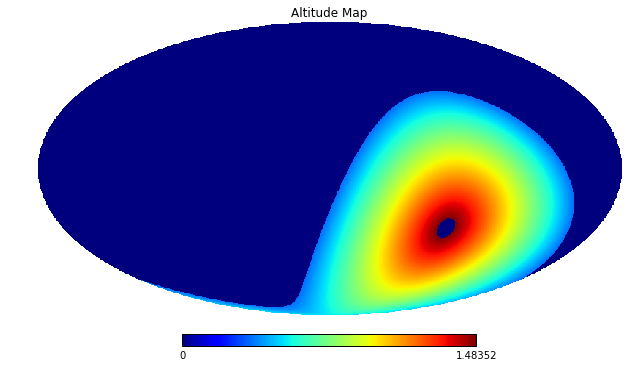

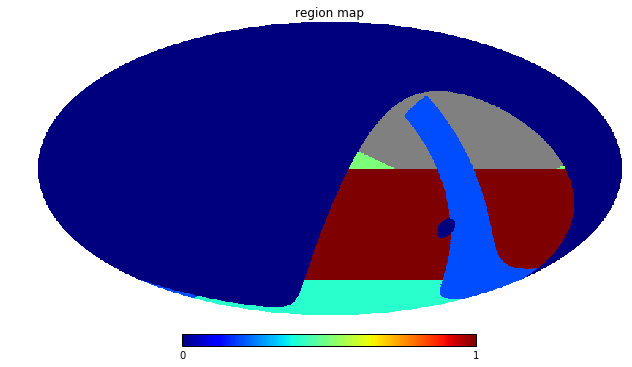

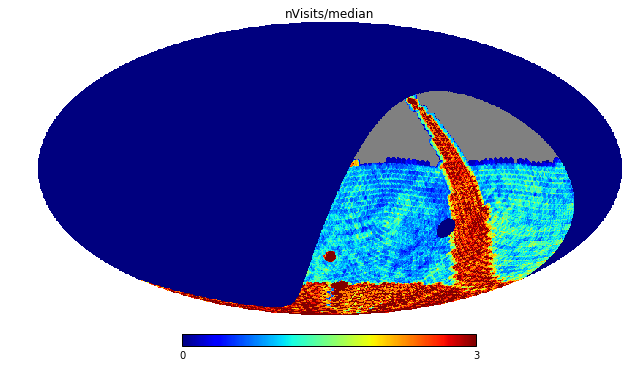

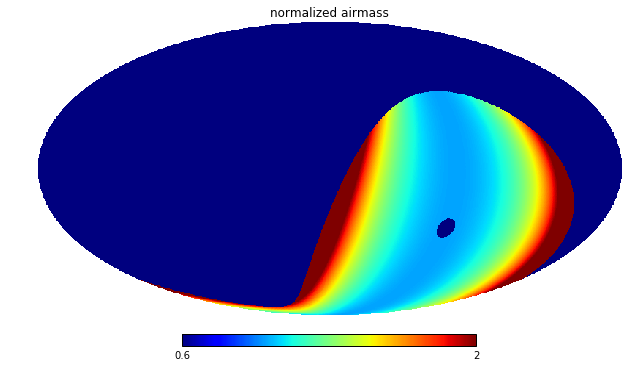

In [11]:
alt = altaz.alt.radian

mask = alt*0+1
mask[np.where(alt > np.radians(90.-5))] = 0
mask[np.where(alt < np.radians(20.))] = 0

hp.mollview(alt*mask, title='Altitude Map')

hp.mollview(regionMap*mask, title='region map')
visitMap = bundleList[0].metricValues/np.median(bundleList[0].metricValues)
visitMap[np.where(bundleList[0].metricValues.mask == True)] = hp.UNSEEN
hp.mollview(visitMap*mask, min=0,max=3, title='nVisits/median')
normAM = 1./np.cos(np.pi/2-alt)
min_z_possible =  np.abs(dec - site.latitude_rad)
min_am_possible =  1. / np.cos(min_z_possible)
normAM = normAM / min_am_possible
hp.mollview(normAM * mask, min=.6, max=2, title='normalized airmass')

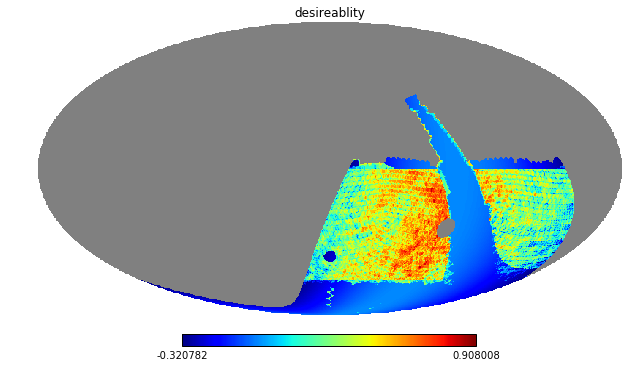

In [12]:
countMap = (regionMap - visitMap)*mask
countMap[np.where(countMap < -1)] = -1
amMap = 1. / normAM
desireability = .5*amMap + 0.5*countMap
desireability[np.where(mask == 0)] = hp.UNSEEN
desireability[np.where(bundleList[0].metricValues.mask == True)] = hp.UNSEEN
hp.mollview(desireability, title='desireablity')

Sigma is 254.796540 arcmin (0.074117 rad) 
-> fwhm is 600.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


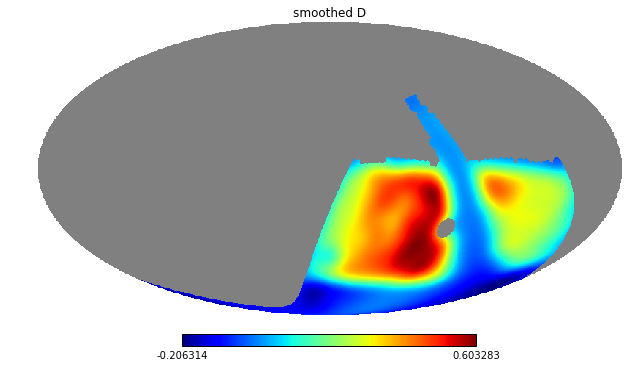

In [13]:
smoothD = hp.sphtfunc.smoothing(desireability, fwhm=np.radians(10.))
hp.mollview(smoothD, title='smoothed D')